# [0] Imports

In [234]:
using LinearAlgebra, Random, Gurobi, JuMP, Distributions, Plots, Dates, FStrings

# [1] Set Up Parameters

In [235]:
low = 10
high = 50
ROUTES = []
XIS = []
JOB_RCS = []
COV_RCS = [];

In [236]:
for JOB in low:high
    n_jobs = JOB
    m_cov = n_jobs
    B = n_jobs
    V = m_cov
    T = 2 * n_jobs
    min_duration = 2
    max_duration = 6
    speed = 500 / 3
    radius = 50
    size = 500
    mesh = 50;
    
    JOB_RC_ARRAY = []
    COV_RC_ARRAY = []

    # [2] Create Job Parameters

    Random.seed!(1234)

    function create_cluster_sizes(jobs_total)
        Random.seed!(1234)
        jobs_created = 0
        cluster = []
        min_jobs_allowed = n_jobs >= 15 ? 3 : 2
            target_clusters = 5
            while jobs_created != jobs_total
                num_to_add = rand(min(min_jobs_allowed, jobs_total - jobs_created) : 
                    min(Int((n_jobs/target_clusters)÷1), jobs_total - jobs_created))
                jobs_created += num_to_add
                push!(cluster, num_to_add)
            end

        return cluster
    end;

    time_windows = []
    locations = rand(Uniform(0,size), 1, 2)
    work_load = []
    cluster = create_cluster_sizes(n_jobs)

    function create_time_windows_and_work_load(cluster_sizes, locations)
        Random.seed!(1234)
        locations = rand(Uniform(0,size), 1, 2)
        for size_c in cluster
            first = rand(Uniform(0,size), 1, 2)
            locations = vcat(locations, first)

            job_begins = rand(2:10)
            job_finish = rand((job_begins+min_duration):(job_begins+max_duration))
            push!(time_windows, [job_begins, job_finish])

            time_work = rand(min_duration:max(min_duration, job_finish - job_begins))
            push!(work_load, time_work)

            for neighbour in 1:(size_c-1)
                new_x = rand(Uniform(max(0,first[1]-20), min(first[1]+20, size)), 1, 1)
                new_y = rand(Uniform(max(0,first[2]-20), min(first[2]+20, size)), 1, 1)
                new = hcat(new_x, new_y)
                locations = vcat(locations, new)

                job_begins = rand(job_finish:min(T-min_duration-2, job_finish + 6))
                job_finish = rand((job_begins+min_duration):(min(job_begins+max_duration, T-2)))
                push!(time_windows, [job_begins, job_finish])

                time_work = rand(min_duration:min(max_duration, job_finish-job_begins))
                push!(work_load, time_work)
            end
        end

        return [time_windows, work_load, locations]
    end

    time_windows, work_load, locations = create_time_windows_and_work_load(cluster, locations)

    function reformat_locations(locations)
        #= The fact that locations[1] gives the same float (not tuple or list)
        as locations[1, 1] and locations[1][2] throws an 
        error is extremely frustrating.
        This function makes locations[1][1] possible, 
        while locations[1] correctly returns a tuple. =#
        locs = []
        for i in 1:Int(length(locations) * 0.5)
            push!(locs, [locations[i,1], locations[i,2]])
        end
        return locs
    end

    job_locs = reformat_locations(locations)
    push!(job_locs, job_locs[1]);

    job_dists = [LinearAlgebra.norm(job_locs[i] .- job_locs[j]) for i=1:n_jobs+2, j = 1:n_jobs+2];

    job_travel_times = ceil.(job_dists / speed);

    # [3] Create Coverage Parameters

    create_all_valid_spots = true;

    function is_close_enough(coverage_loc, job_loc)
        #= Given a coverage_loc with 2 elements x y
        and a job_loc with two elements x y
        determines if that specific job_loc is located within r 
        of the coverage_loc as the crow flies =#
        return (coverage_loc[1]-job_loc[1])^2 + (coverage_loc[2]-job_loc[2])^2 <= radius^2
    end;

    function close_enough_jobs(coverage_loc)
        jobs = []
        for i in 1:n_jobs
            if is_close_enough(coverage_loc, job_locs[i+1])
                push!(jobs, i)
            end
        end
        return jobs
    end;

    cov_locs = []
    seen = []

    for x in 0:mesh:size
        for y in 0:mesh:size
            potential_cov = [x, y]
            useful = false

            if create_all_valid_spots
                for index in 2:length(job_locs)-1
                    if is_close_enough(potential_cov, job_locs[index])
                        useful = true
                        break
                    end
                end
            else
                for job in close_enough_jobs(potential_cov)
                    if ~(job in seen)
                        push!(seen, job)
                        useful = true
                    end
                end
            end

            if useful
                push!(cov_locs, potential_cov)
            end
        end
    end;

    m_cov = length(cov_locs);
    V = m_cov;
    insert!(cov_locs, 1, job_locs[1])
    push!(cov_locs, cov_locs[1]);
    cov_dists = [LinearAlgebra.norm(cov_locs[i] .- cov_locs[j]) for i=1:m_cov+2, j = 1:m_cov+2];
    cov_travel_times = ceil.(cov_dists / speed);

    # [4] Create Initial Job Routes

    job_routes = []

    for i in 1:n_jobs
        route = []
        dist = job_dists[0+1, i+1]

        start_going_time = Int(floor(time_windows[i][1] - dist/speed))
        # time_arrival = time_windows[i][1]
        # time_finished = time_windows[i][2]
        finish_time = time_windows[i][2]
        return_finished = Int(ceil(finish_time + dist/speed))

        push!(route, [[0, start_going_time], [i, time_windows[i][1]], dist])

        for working in time_windows[i][1]:(finish_time-1)
            push!(route, [[i, working], [i, working+1], 0])
        end

        push!(route, [[i, finish_time], [n_jobs+1, return_finished], dist])
        push!(job_routes, route)
    end;

    # [5] Create Initial Coverage Routes

    cov_routes = []

    for j in 1:m_cov
        route = []
        dist = cov_dists[0+1, j+1]

        arrive_time = Int(ceil(dist/speed))
        leave_time = Int(T+1 - ceil(dist/speed))

        push!(route, [[0, 0], [j, arrive_time], dist])

        for t in arrive_time:leave_time-1
            push!(route, [ [j, t], [j, t+1], 0])
        end

        push!(route, [[j, leave_time], [m_cov+1, T+1], dist])
        push!(cov_routes, route)
    end;

    # [6] Helper Functions

    ## [6.1] Compute cost of route

    function route_cost(route)
        ans = 0
        for arc in route
            ans += arc[3]
        end
        return ans
    end;

    ## [6.2] Compute $u_i^q$

    function compute_u(routes)
        Q = length(routes)
        u = [[0 for q in 1:Q] for i in 1:n_jobs]

        for rindex in 1:Q
            route = routes[rindex]
            for arc in route
                loc1 = arc[1][1]
                loc2 = arc[2][1]
                if (1 <= loc1 <= n_jobs)
                    u[loc1][rindex] = 1
                end
                if (1 <= loc2 <= n_jobs)
                    u[loc2][rindex] = 1
                end
            end
        end
        return u
    end;

    ## [6.3] Compute $\delta_{it}^q$

    function compute_delta(routes)
        Q = length(routes)
        delta = [[[0.0 for q in 1:Q] for t in 1:T] for i in 1:n_jobs]
        for rindex in 1:Q
            route = routes[rindex]
            for arc in route
                loc1, time1 = arc[1]
                loc2, time2 = arc[2]
                if (loc1 != 0) & (loc1 != n_jobs + 1)
                    delta[loc1][time1][rindex] = 1
                end

                if (loc2 != 0) & (loc2 != n_jobs + 1)
                    delta[loc2][time2][rindex] = 1
                end
            end
        end
        return delta
    end;

    ## [6.4] Compute $y_{jt}^p$

    function compute_y(routes)
        y = [[[0 for p in 1:length(routes)] for t in 1:T] for j in 1:m_cov]

        for rindex in 1:length(routes)
            route = routes[rindex]
            for arc in route
                job1, time1 = Int.(arc[1])
                job2, time2 = Int.(arc[2])
                if job1 != 0
                    y[job1][time1][rindex] = 1
                end
                if job2 != m_cov + 1
                    y[job2][time2][rindex] = 1
                end
            end
        end
        return y
    end;

    ## [6.5] Compute $L_{ji}$

    function compute_L(cov_locs, job_locs)
        #= Given a list of tuple coverage locations and job locations,
        returns a matrix of L values. Specifically, 
        L[j][i], indicating if spot j is close enough to node i
        for coverage to happen. We might have to delete padding of depot
        first. =#
        L = []
        for j in 2:length(cov_locs)-1
            L_j = []
            cov_loc = cov_locs[j] # padding accounted for
            for i in 2:length(job_locs)-1
                push!(L_j, is_close_enough(cov_loc, job_locs[i]) ? 1 : 0)
            end
            push!(L, L_j)
        end

        return L
    end;

    ## [6.6] Compute $W_{it}$

    function compute_W(job_routes)
        #=
        Given the full solution routes to the job problem,
        tells us W[i][t], which is whether job i is being
        done at time t.

        Our strategy is to gather the FIRST node of each arc,
        because it's the same as the second node of the arc prior.

        Disregard the 1st node (its start is the origin-depot), 
        that information is contained in the 2nd node.
        =#
        W = [ [0 for t in 1:T] for i in 1:n_jobs]

        for route in job_routes
            for arc in route[2:end]
                loc = Int(arc[1][1])
                time = Int(arc[1][2])
                W[loc][time] = 1
            end
        end

        return W
    end;   

    ## [6.7] Compute $j$'s Neighborhood

    function neighborhood(j)
        # returns all nodes i which are close to the spot j.
        cov_loc = cov_locs[j+1] # don't forget padding!

        close = []
        for i in 1:n_jobs
            if is_close_enough(cov_loc, job_locs[i+1])
                push!(close, i)
            end
        end

        return close
    end;

    ## [6.8] Compute coverage stations close to $i$

    function close_covs(i)
        job_loc = job_locs[i+1] # padding included
        close = []
        for j in 1:m_cov
            if is_close_enough(cov_locs[j+1], job_loc)
                push!(close, j)
            end
        end
        return close
    end;

    ## [6.9] Given route, list nodes

    function route_to_nodes(route)
        # get only the 1st node of all arcs except the last, when you get the 2nd
        nodes = []
        for arc in route[1:end-1]
            new_node = arc[1][1]
            push!(nodes, new_node)
        end
        push!(nodes, route[end][2][1])
        return unique(nodes)
    end;

    ## [6.10] Given route, list times

    function route_to_times(route)
        #= Obtain time "markers" when you leave
        or arrive at any node. This is more convenient
        than just telling me when I arrive at any node.
        If the two nodes in an arc are not equal,
        list both of their times. Otherwise, list neither. =#
        times = []
        for arc in route[1:end]
            n1, t1 = arc[1]
            n2, t2 = arc[2]
            if n1 != n2
                push!(times, t1)
                push!(times, t2)
            end
        end
        return times
    end;

    ## [6.11] Given nodes and times, produce route

    function nodes_and_times_to_route(nodes, times, route_type)
        #= Given by two components: When you leave/go between nodes,
        and when you stay. Alternate: start "when you stay",
        then "when you go". For the first node there is no stay. 
        For the last node there is no stay nor go.=#
        route = []
        for i in 1:length(nodes)-1

            # WHEN YOU STAY
            if i > 1
                n = nodes[i]
                t1 = times[2*i-2]
                t2 = times[2*i-1]

                for t in t1:t2-1
                    arc = [[n, t], [n, t+1], 0]
                    push!(route, arc)
                end
            end

            # WHEN YOU GO
            n1 = nodes[i]
            n2 = nodes[i+1]
            t1 = times[2*i-1]
            t2 = times[2*i]
            dist = route_type == "job" ? job_dists[n1+1, n2+1] : cov_dists[n1+1, n2+1]
            arc = [[n1, t1], [n2, t2], dist]
            push!(route, arc)
        end
        return route
    end;       

    ## [6.12] When to Enter a Spot

    function when_to_enter(spot, windows)
        neigh = neighborhood(spot)
        enterable_times = []
        for t in [windows[i][1] for i in neigh]
            # no job is being done...basically can't be > time_windows[1] and <= time_windows[2]
            can_enter = true
            for job in neigh
                if t > windows[job][1] && t <= windows[job][2]
                    can_enter = false
                end
            end

            if can_enter
                push!(enterable_times, t)
            end
        end
        return enterable_times
    end;

    ## [6.13] When to Leave a Spot

    function when_to_leave(spot, windows)
        neigh = neighborhood(spot)
        leavable_times = []
        for t in [windows[i][2] for i in neigh]
            can_leave = true
            for job in neigh
                if t >= windows[job][1] && t < windows[job][2]
                    can_leave = false
                end
            end

            if can_leave
                push!(leavable_times, t)
            end
        end
        return leavable_times
    end;

    ## [6.14] All Jobs Finished at Spot

    function all_jobs_ended(spot, windows)
        last = -Inf
        for i in neighborhood(spot)
            if windows[i][2] > last
                last = windows[i][2]
            end
        end
        return last
    end;

    ## [6.15] Clip time windows based on coverage availability

    function clip_time_windows_by_cov(time_windows, cov_routes, job_routes, x, z, delta, y)
        new_windows = []

        P = length(cov_routes)
        Q = length(job_routes)

        for i in 1:length(time_windows)

            cc = close_covs(i)

            found_start = false
            t = time_windows[i][1]
            start_t = time_windows[i][1]
            while ~found_start
                total_cov = sum(sum(y[j][t][p] * x[p] for j in cc) for p in 1:P)

                work_job = sum(z[q] * delta[i][t][q] for q in 1:Q)

                if total_cov >= 1 - 1e-8 || total_cov >= work_job - 1e-8
                    found_start = true
                    start_t = t
                    break
                else
                    t += 1
                end
            end

            found_end = false
            t = time_windows[i][2]
            finish_t = time_windows[i][2]
            while ~found_end
                total_cov = sum(sum(y[j][t][p] * x[p] for j in cc) for p in 1:P)

                work_job = sum(z[q] * delta[i][t][q] for q in 1:Q)

                if total_cov >= 1 - 1e-8 || total_cov >= work_job - 1e-8
                    found_end = true
                    finish_t = t
                    break
                else
                    t -= 1
                end
            end

            push!(new_windows, [start_t, finish_t])
        end

        return new_windows
    end;

    ## [6.16] Produce work windows based on job routes

    function work_windows(job_routes, z)
        work_windows_ = []
        delta = compute_delta(job_routes)

        for i in 1:n_jobs
            work_window = []
            for t in 1:T
                if sum(z[q] * delta[i][t][q] for q in 1:length(job_routes)) >= 1e-4
                    push!(work_window, t)
                end
            end
            #if length(work_window) != 0 - used for tinkering
            push!(work_windows_, [first(work_window), last(work_window)])
            #end
        end

        return work_windows_
    end;

    # [7] Subproblem and Loop Helper Functions

    ## [7.1] Extract Best Route

    # Given a set of node_sequences, time_sequences, rcs, return the best ROUTE.

    function extract_best_route(node_seq, time_seq, rcs, route_type="job", include_rc = false)
        mindex = -1
        best_rc = Inf

        for index in 1:length(node_seq)
            if rcs[index] < -1e-5 && rcs[index] < best_rc &&
                ((route_type == "job" && last(node_seq[index]) == n_jobs+1) || 
                    (route_type != "job" && last(node_seq[index]) == m_cov + 1))
                best_rc = rcs[index]
                mindex = index
            end
        end

        if mindex == -1 || best_rc >= -1e-10
            if ~include_rc
                return []
            else
                return [], 0
            end
        end

        if ~include_rc
            return nodes_and_times_to_route(node_seq[mindex], time_seq[mindex], route_type)
        else
            return nodes_and_times_to_route(node_seq[mindex], time_seq[mindex], route_type), best_rc
        end
    end;

    ## [7.2] Recover z Objective

    function recover_z_obj(last_z, z_routes)
        total = 0
        for rindex in 1:length(z_routes)
            total += last_z[rindex] * route_cost(z_routes[rindex])
        end
        return total
    end;

    ## [7.3] Recover x Objective

    function recover_x_obj(last_x, x_routes)
        total = 0
        for xindex in 1:length(x_routes)
            total += last_x[xindex] * route_cost(x_routes[xindex])
        end
        return total
    end;

    ## [7.4] Golden Intervals

    function all_nuggets(xi_values, j)
        #= Given xi values and a spot j,
        return all pairs (i, t) where a nugget lies. =#
        nuggets = []
        for i in neighborhood(j)
            for t in 1:T
                if xi_values[i, t] > 1e-8
                    push!(nuggets, [i, t])
                end
            end
        end
        return nuggets
    end;

    function nugget_interval(times, arrivals, departs)
        start_nugget_time = sort(times)[1]
        finish_nugget_time = sort(times)[end]
        arrival_time = Inf
        depart_time = 0
        for arrival in reverse(sort(arrivals))
            if arrival <= start_nugget_time
                arrival_time = arrival
                break
            end
        end

        for depart in sort(departs)
            if depart >= finish_nugget_time
                depart_time = depart
                break
            end
        end

        return [arrival_time, depart_time]
    end;

    function golden_intervals(xi_values, windows_)
        answer = []
        for j in 1:m_cov
            intervals_for_j = []
            j_nuggets = all_nuggets(xi_values, j) # pairs [i, t]

            ats = when_to_enter(j, windows_)
            dts = when_to_leave(j, windows_)

            nugget_times = unique([j_nuggets[i][2] for i in 1:length(j_nuggets)])

            for sindex in 1:length(nugget_times)
                for tindex in sindex:length(nugget_times)
                    nug_int = nugget_interval([nugget_times[sindex], nugget_times[tindex]], ats, dts)
                    if nug_int[1] != Inf && nug_int[2] != 0
                        push!(intervals_for_j, nug_int)
                    end
                end
            end

            unique!(intervals_for_j)

            intervals_with_rcs = []

            for interval in intervals_for_j
                total = 0
                for nugget in j_nuggets
                    if interval[1] <= nugget[2] <= interval[2]
                        total += xi_values[nugget[1], nugget[2]]
                    end
                end
                push!(intervals_with_rcs, [interval, total])
            end
            push!(answer, intervals_with_rcs)
        end
        return answer
    end;

    # [8] Subproblem Algorithms

    ## [8.1] Jobs Alone

    function jobs_alone_sp(n_jobs, job_dists, job_travel_times, windows, loads, rho, pi_i)
        N = [[0]] 
        Times = [[0]] 
        R = [rho]
        NRC = [Inf for i in 1:n_jobs]

        current_state = 1
        total_state = 1

        while true
            cur_path = N[current_state]
            last_cur_node = last(cur_path)
            cur_times = Times[current_state]

            if last_cur_node == n_jobs+1
                current_state += 1
                if current_state > total_state
                    break
                else
                    continue
                end
            end

            for i in 1:n_jobs+1
                if ~(i in cur_path)

                    # check time
                    prev_depart_time = last(cur_times)
                    time_to_travel = job_travel_times[last_cur_node+1, i+1]
                    new_job_load = i <= n_jobs ? loads[i] : 0
                    new_window_start, new_window_close = i <= n_jobs ? (windows[i]) : ([0, T+1])

                    proposed_arrival_time = prev_depart_time + time_to_travel

                    if proposed_arrival_time + new_job_load > new_window_close
                        continue
                    end

                    reach_new_node_time = max(proposed_arrival_time, new_window_start)

                    # check not prunable
                    add_C = job_dists[last_cur_node+1, i+1]
                    subtract_pi = i <= n_jobs ? -pi_i[i] : 0

                    proposed_cost = R[current_state] + add_C + subtract_pi

                    if i <= n_jobs
                        if proposed_cost > NRC[i] + 1e-8
                            continue
                        else
                            NRC[i] = proposed_cost
                        end
                    end

                    # push
                    push!(N, copy(cur_path))
                    push!(N[total_state+1], i)

                    new_time_array = copy(cur_times)
                    push!(new_time_array, reach_new_node_time)
                    if i <= n_jobs
                        push!(new_time_array, reach_new_node_time+new_job_load)
                    end
                    push!(Times, new_time_array)

                    push!(R, proposed_cost)

                    total_state += 1

                end
            end

            current_state += 1 

            if current_state >= total_state
                break
            end     
        end

        return N, Times, R
    end;

    ## [8.2] Jobs in Conjunction with Coverage

    function jobs_with_cov_sp(n_jobs, job_dists, job_travel_times, windows, loads, rho, pi_i, xi_it)
        N = [[0]]
        Times = [[0]]
        R = [rho]
        NRC = [Inf for i in 1:n_jobs+1]

        current_state = 1
        total_state = 1

        while true
            cur_path = N[current_state]
            last_cur_node = last(cur_path)
            cur_times = Times[current_state]

            if last_cur_node == n_jobs+1
                current_state += 1
                if current_state > total_state
                    break
                else
                    continue
                end
            end

            for i in 1:n_jobs+1
                if ~(i in cur_path)

                    # check time
                    prev_depart_time = last(cur_times)
                    time_to_travel = job_travel_times[last_cur_node+1, i+1]
                    new_job_load = i <= n_jobs ? loads[i] : 0
                    new_window_start = i <= n_jobs ? windows[i][1] : 0
                    new_window_close = i <= n_jobs ? windows[i][2] : T+1

                    proposed_arrival_time = prev_depart_time + time_to_travel

                    if proposed_arrival_time + new_job_load > new_window_close
                        continue
                    end

                    reach_new_node_time = max(proposed_arrival_time, new_window_start)
                    depart_time = reach_new_node_time + new_job_load

                    # check not prunable
                    add_C = job_dists[last_cur_node+1, i+1]
                    subtract_pi = i <= n_jobs ? -pi_i[i] : 0

                    proposed_cost = R[current_state] + add_C + subtract_pi

                    for t in reach_new_node_time:depart_time
                        proposed_cost += i <= n_jobs ? xi_it[i, Int(t)] : 0
                    end

                    if i <= n_jobs
                        if proposed_cost > NRC[i]
                            continue
                        else
                            NRC[i] = proposed_cost + 1e-8
                        end
                    end

                    push!(N, copy(cur_path))
                    push!(N[total_state+1], i)

                    new_time_array = copy(cur_times)
                    push!(new_time_array, reach_new_node_time)
                    if i <= n_jobs
                        push!(new_time_array, depart_time)
                    end
                    push!(Times, new_time_array)

                    push!(R, proposed_cost)

                    total_state += 1
                end
            end

            current_state += 1

            if current_state == total_state
                break
            end
        end

        return N, Times, R
    end;

    ## [8.3] Coverage

    function cov_sp(cov_dists, cov_travel_times, windows, beta, xi_it)
        N = [[0]]
        Times = [[0]]
        R = [beta]
        NRC = [Inf for j in 1:m_cov+1]

        current_state = 1
        total_state = 1

        while true
            cur_path = N[current_state]
            last_cur_node = last(cur_path)
            cur_times = Times[current_state]

            if last_cur_node == m_cov+1
                current_state += 1
                if current_state > total_state
                    break
                else
                    continue
                end
            end

            for j in 1:m_cov+1
                if j != last_cur_node
                    #anything goes.
                    prev_depart_time = last(cur_times)
                    travel_time = cov_travel_times[last_cur_node+1, j+1]
                    # You are ONLY allowed to arrive at times when specified by when_to_enter.
                    arrival_times = (j <= m_cov) ? when_to_enter(j, windows) : [prev_depart_time + travel_time]
                    departure_times = (j <= m_cov) ? when_to_leave(j, windows) : [prev_depart_time+travel_time+1]

                    for at in arrival_times

                        if at < prev_depart_time + travel_time # impossible to arrive then
                            continue
                        end
                        # otherwise we're fine

                        # now we have to consider ALL possible departure times.
                        for dt in departure_times

                            if dt <= at # if you depart when you arrive, what's the point?
                                continue
                            end
                            #only viable departure times remain

                            cur_rc = R[current_state]
                            add_C = cov_dists[last_cur_node+1, j+1]
                            cur_rc += add_C

                            for t in at:dt
                                for i in neighborhood(j)
                                    cur_rc -= j <= m_cov ? xi_it[i, Int(t)] : 0
                                end
                            end

                            if j <= m_cov
                                if cur_rc < NRC[j] || cur_rc < -1e-8 && cur_rc < NRC[j] + 1e-8
                                    NRC[j] = cur_rc
                                else
                                    continue
                                end
                            end

                            push!(N, copy(cur_path))
                            push!(N[total_state+1], j)

                            new_time_array = copy(cur_times)
                            push!(new_time_array, at)
                            if j <= m_cov
                                push!(new_time_array, dt)
                            end

                            push!(Times, new_time_array)

                            push!(R, cur_rc)

                            total_state += 1
                        end
                    end
                end
            end

            current_state += 1

            if current_state == total_state
                break
            end
        end

        return N, Times, R
    end;

    ## [8.4] Intervaled Coverage

    function cov_sp_interval(cov_dists, cov_travel_times, windows, beta, xi_it)
        N = [[0]]
        Times = [[0]]
        R = [beta]
        NRC = [Inf for j in 1:m_cov+1]
        GOLDEN_INTERVALS = golden_intervals(xi_it, windows)

        current_state = 1
        total_state = 1

        while true
            cur_path = N[current_state]
            last_cur_node = last(cur_path)
            cur_times = Times[current_state]

            if last_cur_node == m_cov+1
                current_state += 1
                if current_state > total_state
                    break
                else
                    continue
                end
            end

            for j in 1:m_cov+1
                if j != last_cur_node

                    prev_depart_time = last(cur_times)
                    travel_time = cov_travel_times[last_cur_node+1, j+1]

                    if j == m_cov + 1
                        cur_rc = R[current_state]
                        add_C = cov_dists[last_cur_node+1, j+1]
                        cur_rc += add_C
                        push!(R, cur_rc)

                        push!(N, copy(cur_path))
                        push!(N[total_state+1], j)

                        new_time_array = copy(cur_times)
                        push!(new_time_array, prev_depart_time + travel_time)
                        push!(Times, new_time_array)
                        total_state += 1
                    else
                        for interval in GOLDEN_INTERVALS[j]
                            at, dt = interval[1]
                            minus_xi = interval[2]

                            if at < prev_depart_time + travel_time # too early
                                continue
                            end

                            cur_rc = R[current_state]
                            cur_rc += cov_dists[last_cur_node+1, j+1]
                            #=
                            for t in at:dt
                                for i in neighborhood(j)
                                    cur_rc -= xi_it[i, Int(t)]
                                end
                            end
                            =#
                            cur_rc -= minus_xi

                            if cur_rc < NRC[j]
                                NRC[j] = cur_rc
                            else
                                continue
                            end

                            push!(R, cur_rc)

                            push!(N, copy(cur_path))
                            push!(N[total_state+1], j)

                            new_time_array = copy(cur_times)
                            push!(new_time_array, at)
                            push!(new_time_array, dt)
                            push!(Times, new_time_array)

                            total_state += 1
                        end
                    end
                end
            end

            current_state += 1

            if current_state >= total_state
                break
            end
        end

        return N, Times, R
    end;

    # [9] Column Generation Loops

    ## [9.1] Jobs alone without/with coverage

    function colgen_jobs_alone(job_routes, job_dists, job_travel_times, windows, loads, with_coverage=false, cov_rts=[], final_x=[])
        model = Model(Gurobi.Optimizer)
        set_optimizer_attribute(model, "OutputFlag", 0)

        u = compute_u(job_routes)
        C = [route_cost(route) for route in job_routes]
        Q = length(job_routes)

        true_windows = deepcopy(windows)
        last_z = [1 for i in 1:Q]

        if with_coverage
            delta = compute_delta(job_routes)
            y = compute_y(cov_rts)
            true_windows = clip_time_windows_by_cov(windows, cov_rts, job_routes, final_x, last_z, delta, y)
        end

        job_objective = Inf

        while true
            unregister(model, :z)
            @variable(model, 0 <= z[1:Q] <= 1)

            unregister(model, :unique)
            @constraint(model, unique[i in 1:n_jobs], sum(u[i][q] * z[q] for q in 1:Q) >= 1);

            unregister(model, :driver)
            @constraint(model, driver, sum(z[q] for q in 1:Q) <= B)

            @objective(model, Min, sum(C[q] * z[q] for q in 1:Q));

            optimize!(model)
            job_objective = objective_value(model)
            last_z = value.(z)

            pi_values = dual.(unique)
            rho_value = dual.(driver)

            if with_coverage
                delta = compute_delta(job_routes)
                y = compute_y(cov_rts)
                true_windows = clip_time_windows_by_cov(windows, cov_rts, job_routes, final_x, last_z, delta, y)
            end

            node_seq, time_seq, rcs = jobs_alone_sp(n_jobs, job_dists, job_travel_times, true_windows, loads, rho_value, pi_values)

            new_route = extract_best_route(node_seq, time_seq, rcs, "job")

            if length(new_route) == 0
                break
            end

            push!(job_routes, new_route)

            u = compute_u(job_routes)
            delta = compute_delta(job_routes)
            C = [route_cost(route) for route in job_routes]
            Q = length(job_routes)
        end

        return job_routes, last_z, job_objective
    end;

    ## [9.2] Jobs and Coverage

    function colgen_jobs_and_cov(job_routes, cov_routes, job_dists, job_travel_times, windows, loads, cov_dists, cov_travel_times, no_suspense_please=true)
        model = Model(Gurobi.Optimizer)
        set_optimizer_attribute(model, "OutputFlag", 0)

        u = compute_u(job_routes)
        delta = compute_delta(job_routes)
        C_q = [route_cost(route) for route in job_routes]
        C_p = [route_cost(route) for route in cov_routes]
        L = compute_L(cov_locs, job_locs)
        Q = length(job_routes)
        P = length(cov_routes)
        y = compute_y(cov_routes)

        last_z = [1 for i in 1:n_jobs]
        last_x = [1 for j in 1:m_cov]
        full_objective = Inf

        xis = []

        while true

            unregister(model, :z)
            @variable(model, 0 <= z[1:Q] <= 1);
            unregister(model, :x)
            @variable(model, 0 <= x[1:P] <= 1);

            unregister(model, :job_visited_once)
            @constraint(model, job_visited_once[i in 1:n_jobs], sum(u[i][q] * z[q] for q in 1:Q) >= 1);
            unregister(model, :enough_job_vehicles)
            @constraint(model, enough_job_vehicles, sum(z[q] for q in 1:Q) <= B);
            unregister(model, :enough_cov_vehicles)
            @constraint(model, enough_cov_vehicles, sum(x[p] for p in 1:P) <= V);
            unregister(model, :must_be_covered)
            @constraint(model, must_be_covered[i in 1:n_jobs, t in 1:T], 
            sum(sum(y[j][t][p] * x[p] for p in 1:P) for j in close_covs(i)) >= 
            sum(z[q] * delta[i][t][q] for q in 1:Q));

            @objective(model, Min, 
                sum(C_q[q] * z[q] for q in 1:Q) + 
                sum(C_p[p] * x[p] for p in 1:P));

            optimize!(model)

            full_objective = objective_value(model)
            last_z = value.(z)
            last_x = value.(x)

            if no_suspense_please
                println(full_objective)
            end

            pi = dual.(job_visited_once)
            rho = dual.(enough_job_vehicles)
            beta = dual.(enough_cov_vehicles)
            xi = dual.(must_be_covered)
            push!(xis, xi)

            true_windows_for_cov = work_windows(job_routes, last_z)
            true_windows_for_job = clip_time_windows_by_cov(windows, cov_routes, job_routes, last_x, last_z, delta, y)

            job_node_seqs, job_time_seqs, job_rcs = jobs_with_cov_sp(n_jobs, job_dists, job_travel_times, true_windows_for_job, loads, rho, pi, xi)
            cov_node_seqs, cov_time_seqs, cov_rcs = cov_sp_interval(cov_dists, cov_travel_times, true_windows_for_cov, beta, xi)

            new_job_route, job_rc = extract_best_route(job_node_seqs, job_time_seqs, job_rcs, "job", true)
            new_cov_route, cov_rc = extract_best_route(cov_node_seqs, cov_time_seqs, cov_rcs, "cov", true)
            push!(JOB_RC_ARRAY, job_rc)
            push!(COV_RC_ARRAY, cov_rc)

            if length(new_job_route) == 0 && length(new_cov_route) == 0
                break
            end

            if length(new_job_route) > 0
                push!(job_routes, new_job_route)
            end

            if length(new_cov_route) > 0
                push!(cov_routes, new_cov_route)
            end

            u = compute_u(job_routes)
            delta = compute_delta(job_routes)
            C_q = [route_cost(route) for route in job_routes]
            C_p = [route_cost(route) for route in cov_routes]
            L = compute_L(cov_locs, job_locs)
            Q = length(job_routes)
            P = length(cov_routes)
            y = compute_y(cov_routes)

        end

        return job_routes, cov_routes, last_z, last_x, full_objective, xis
    end;

    ## [9.3] Coverage Only

    function colgen_cov_only(cov_routes, job_routes, cov_dists, cov_travel_times, final_z)
        model = Model(Gurobi.Optimizer)
        set_optimizer_attribute(model, "OutputFlag", 0)

        W = compute_W(job_routes)
        Q = length(job_routes)

        L = compute_L(cov_locs, job_locs)
        y = compute_y(cov_routes)
        P = length(cov_routes)
        C = [route_cost(route) for route in cov_routes]

        true_windows = work_windows(job_routes, final_z)

        last_x = []
        cov_objective = Inf

        while true
            unregister(model, :x)
            @variable(model, 0 <= x[1:P] <= 1);

            unregister(model, :enough_vehicles)
            unregister(model, :work_covered)
            @constraint(model, enough_vehicles, sum(x[p] for p in 1:P) <= V);
            @constraint(model, work_covered[i in 1:n_jobs, t in 1:T], 
            sum(sum(y[j][t][p] * x[p] for j in close_covs(i)) for p in 1:P) >= W[i][t]);

            @objective(model, Min, sum(x[p] * C[p] for p in 1:P));

            optimize!(model)
            cov_objective = objective_value(model)
            last_x = value.(x)

            beta = dual.(enough_vehicles)
            xi = dual.(work_covered)

            node_seq, time_seq, rcs = cov_sp(cov_dists, cov_travel_times, true_windows, beta, xi)

            new_route = extract_best_route(node_seq, time_seq, rcs, "cov")

            if length(new_route) < 1
                break
            end

            push!(cov_routes, new_route)

            L = compute_L(cov_locs, job_locs)
            y = compute_y(cov_routes)
            P = length(cov_routes)
            C = [route_cost(route) for route in cov_routes]
        end

        return cov_routes, last_x, cov_objective
    end;

    # [10] Run!

    last_z = colgen_jobs_alone(job_routes, job_dists, job_travel_times, time_windows, work_load)[2];
    job_routes, cov_routes, last_z, last_x, full_objective, xis = colgen_jobs_and_cov(job_routes, cov_routes, job_dists, job_travel_times, time_windows, work_load, cov_dists, cov_travel_times, false);
   
    push!(ROUTES, cov_routes[m_cov+1:end])
    push!(XIS, xis)
    push!(JOB_RCS, JOB_RC_ARRAY)
    push!(COV_RCS, COV_RC_ARRAY)
end;

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04

# [11] Data for Analysis

In [237]:
function h16(number)
    first = Int(floor(number/16))
    second = number - first * 16
    
    key = ["0","1","2","3","4","5","6","7","8","9","A","B","C","D","E","F"]
    return key[first+1] * key[second+1]
end;

## [11.1] Reduced Costs

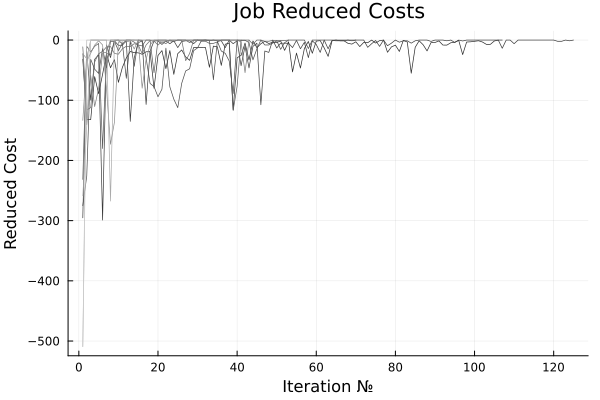

In [341]:
plot(title="Job Reduced Costs")
for job in high:-4:low
    color = h16(202-(job-low)*4)
    plot!([i for i in 1:length(JOB_RCS[job-10+1])], JOB_RCS[job-10+1], label=f"{job}", color=f"#{color}{color}{color}", linewidth=0.7)
end
display(plot!(xlabel="Iteration №", ylabel="Reduced Cost", legend=:none))

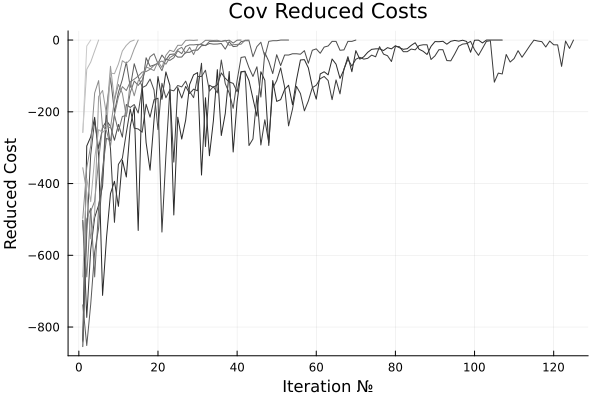

In [346]:
plot(title="Cov Reduced Costs")
for job in high:-4:low
    color = h16(202-(job-low)*4)
    plot!([i for i in 1:length(COV_RCS[job-10+1])], COV_RCS[job-10+1], label=f"{job}", color=f"#{color}{color}{color}")
end
display(plot!(xlabel="Iteration №", ylabel="Reduced Cost", legend=:none))

## [11.2] Frequency of Route Analysis

In [240]:
function route_to_nodes(route)
    # get only the 1st node of all arcs except the last, when you get the 2nd
    nodes = []
    for arc in route[1:end-1]
        new_node = arc[1][1]
        push!(nodes, new_node)
    end
    push!(nodes, route[end][2][1])
    return unique(nodes)
end;

In [241]:
function route_to_times(route)
        #= Obtain time "markers" when you leave
        or arrive at any node. This is more convenient
        than just telling me when I arrive at any node.
        If the two nodes in an arc are not equal,
        list both of their times. Otherwise, list neither. =#
        times = []
        for arc in route[1:end]
            n1, t1 = arc[1]
            n2, t2 = arc[2]
            if n1 != n2
                push!(times, t1)
                push!(times, t2)
            end
        end
        return times
    end;

In [242]:
function dict_nodes(cov_routes)
    seen_freqs = Dict()
    
    for rindex in 1:length(cov_routes)
        new_route = route_to_nodes(cov_routes[rindex])
        if new_route in keys(seen_freqs)
            seen_freqs[new_route] += 1
        else
            seen_freqs[new_route] = 1
        end
    end
    return seen_freqs #sort(collect(seen_freqs), by = candidate -> -candidate[2])
end;

In [243]:
function dict_nodes_times(cov_routes)
    seen_freqs = Dict()
    
    for rindex in 1:length(cov_routes)
        new_route = route_to_nodes(cov_routes[rindex])
        new_times = route_to_times(cov_routes[rindex])
        if new_route in keys(seen_freqs)
            seen_freqs[[new_route, new_times]] += 1
        else
            seen_freqs[[new_route, new_times]] = 1
        end
    end
    return seen_freqs # sort(collect(seen_freqs), by = candidate -> -candidate[2])
end;

In [244]:
function histogram(freqs)
    x = [0.0]
    y = [0.0]
    sort!(freqs)
    total = sum(freqs)
    for i in 1:length(freqs)
        push!(x, i/length(freqs))
        push!(y, round.(freqs[i]/total + y[end], digits=10))
    end
    
    return [x, y]
end;

function extract_freqs(dictionary)
    return [value for value in values(dictionary)]
end;

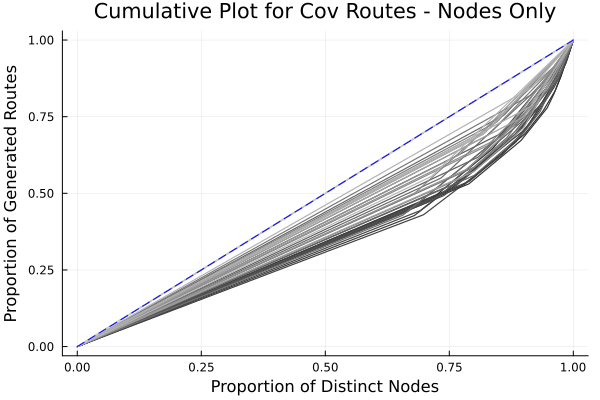

In [347]:
plot(title="Cumulative Plot for Cov Routes - Nodes Only")
for job in high:-1:low
    hist = histogram(extract_freqs(dict_nodes(ROUTES[job-low+1])))
    color = h16(202-(job-low)*4)
    plot!(hist[1], hist[2], label=f"{job}", color=f"#{color}{color}{color}", linewidth=1.2)
end;

display(plot!([0, 1], [0, 1], linestyle=:dash, legend=:none, color=:blue, xlabel="Proportion of Distinct Nodes", ylabel="Proportion of Generated Routes"))

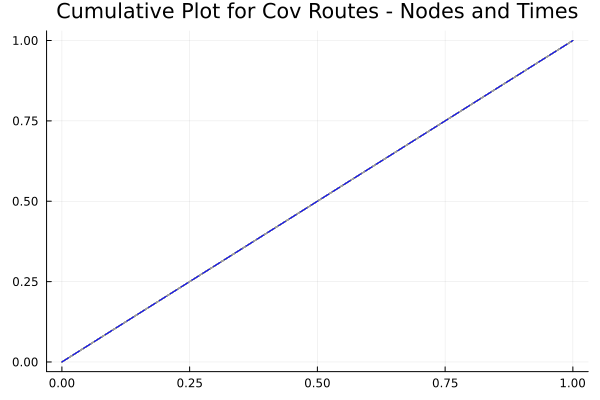

In [348]:
plot(title="Cumulative Plot for Cov Routes - Nodes and Times")
for job in low:high
    color = h16(255-job*2)
    hist = histogram(extract_freqs(dict_nodes_times(ROUTES[job-low+1])))
    plot!(hist[1], hist[2], label=f"{job}", color=f"#{color}{color}{color}")
end;

display(plot!([0, 1], [0, 1], linestyle=:dash, legend=:none, color=:blue))

## [11.3] Xi Values

### [11.3.1] Cumulative Distribution

In [247]:
function find_nuggets(xi_iter, I, T)
    # for a single iteration of xi, we find where xi > 0.
    # Include [i, t, rc] as well.
    nuggets = []
    for i in 1:I
        for t in 1:T
            if xi_iter[i, t] >= 1e-8
                push!(nuggets, [i, t, xi_iter[i, t]])
            end
        end
    end
    return nuggets
end;

In [248]:
function dict_xis_with_rcs(xis, I, T)
    seen_freqs = Dict()
    
    for xi_iter in xis
        nuggets = find_nuggets(xi_iter, I, T)
        for nugget in nuggets
            if nugget in keys(seen_freqs)
                seen_freqs[nugget] += 1
            else
                seen_freqs[nugget] = 1
            end
        end
    end
    
    return seen_freqs
end;

In [249]:
function dict_xis(xis, I, T)
    seen_freqs = Dict()
    
    for xi_iter in xis
        nuggets = find_nuggets(xi_iter, I, T)
        for nugget in nuggets
            nugget = deepcopy(nugget)[1:2]
            if nugget in keys(seen_freqs)
                seen_freqs[nugget] += 1
            else
                seen_freqs[nugget] = 1
            end
        end
    end
    
    return seen_freqs
end;

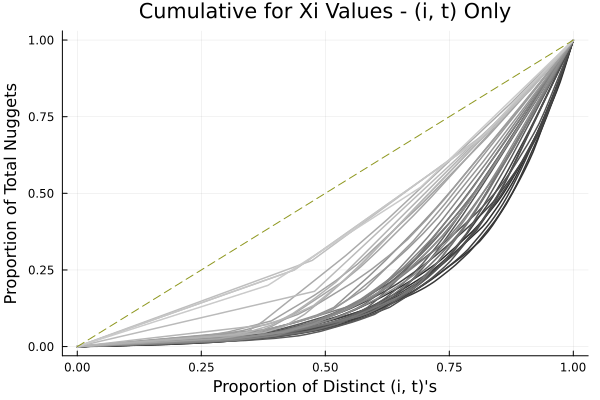

In [332]:
plot(title="Cumulative for Xi Values - (i, t) Only")
for job in high:-1:low
    color = h16(202-(job-low)*4)
    hist = histogram(extract_freqs(dict_xis(XIS[job-low+1], job, job*2)))
    plot!(hist[1], hist[2], label=f"{job}", color=f"#{color}{color}{color}", linewidth=1.5)
end;

display(plot!([0, 1], [0, 1], linestyle=:dash, legend=:none, xlabel="Proportion of Distinct (i, t)'s", ylabel="Proportion of Total Nuggets"))

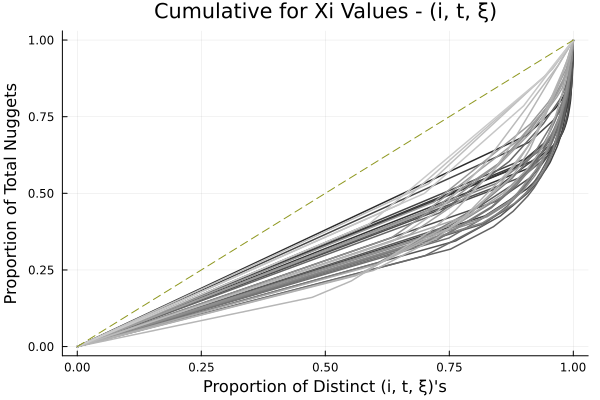

In [331]:
plot(title="Cumulative for Xi Values - (i, t, ξ)")
for job in high:-1:low
    color = h16(202-(job-low)*4)
    hist = histogram(extract_freqs(dict_xis_with_rcs(XIS[job-low+1], job, job*2)))
    plot!(hist[1], hist[2], label=f"{job}", color=f"#{color}{color}{color}", linewidth=1.5)
end;

display(plot!([0, 1], [0, 1], linestyle=:dash, legend=:none, xlabel="Proportion of Distinct (i, t, ξ)'s", ylabel="Proportion of Total Nuggets"))

### [11.3.2] Nugget Changes

In [297]:
function nugget_changes(nuggets1, nuggets2, proportion=true)
    gone = 0
    changed = 0
    for nugget in nuggets1
        if nugget[1:2] in [nug[1:2] for nug in nuggets2]
            if ~(round.(nugget, digits=6) in [round.(nug, digits=6) for nug in nuggets2])
                changed += 1
            end
        end
        
        if ~(nugget[1:2] in [nug[1:2] for nug in nuggets2])
            gone += 1
        end
    end
    if proportion
        return [gone/length(nuggets1), changed/length(nuggets1)]
    else
        return [gone, changed]
    end
end;

In [298]:
# Fetch Proportions and Raw Numbers
prop_gone = []
prop_changed = []
num_gone = []
num_changed = []

for job in low:high
    pg, pch, ng, nch = [], [], [], []
    for iteration in 1:length(XIS[job-low+1])-1
        xi_iter = XIS[job-low+1][iteration]
        xi_next = XIS[job-low+1][iteration+1]
        prop_data = nugget_changes(find_nuggets(xi_iter, job, job*2), find_nuggets(xi_next, job, job*2))
        ex_data = nugget_changes(find_nuggets(xi_iter, job, job*2), find_nuggets(xi_next, job, job*2), false)
        push!(pg, prop_data[1])
        push!(pch, prop_data[2])
        push!(ng, ex_data[1])
        push!(nch, ex_data[2])
    end
    
    push!(prop_gone, pg)
    push!(prop_changed, pch)
    push!(num_gone, ng)
    push!(num_changed, nch)
end;

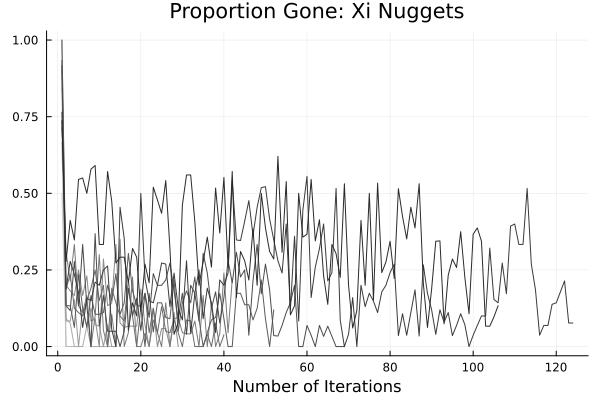

In [339]:
plot(title="Proportion Gone: Xi Nuggets")

for job in low:4:high
    color = h16(202-(job-low)*4)
    plot!([i for i in 1:length(prop_gone[job-low+1])], prop_gone[job-low+1], color=f"#{color}{color}{color}", linewidth=1)
end

display(plot!(legend=:none, xlabel="Number of Iterations"))

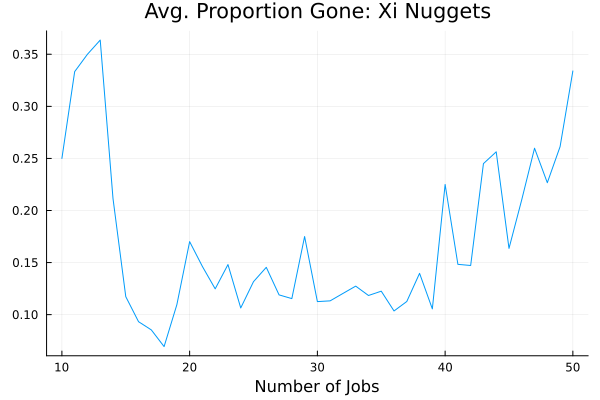

In [315]:
# get the average proportion gone
avg_prop_gone = []
plot(title="Avg. Proportion Gone: Xi Nuggets")
for job in low:high
    push!(avg_prop_gone, sum(prop_gone[job-low+1])/length(prop_gone[job-low+1]))
end

plot!([i for i in low:high], avg_prop_gone, legend=:none, xlabel="Number of Jobs")

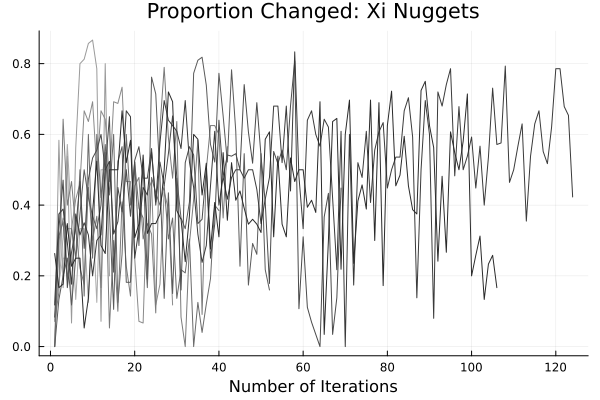

In [336]:
plot(title="Proportion Changed: Xi Nuggets")

for job in low:4:high
    color = h16(202-(job-low)*4)
    plot!([i for i in 1:length(prop_changed[job-low+1])], prop_changed[job-low+1], color=f"#{color}{color}{color}", linewidth=1)
end

display(plot!(legend=:none, xlabel="Number of Iterations"))

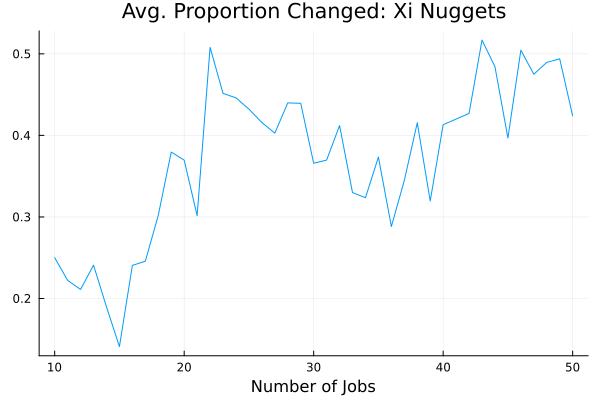

In [323]:
# get the average proportion changed
avg_prop_ch = []
plot(title="Avg. Proportion Changed: Xi Nuggets")
for job in low:high
    push!(avg_prop_ch, sum(prop_changed[job-low+1])/length(prop_changed[job-low+1]))
end

plot!([i for i in low:high], avg_prop_ch, legend=:none, xlabel="Number of Jobs")

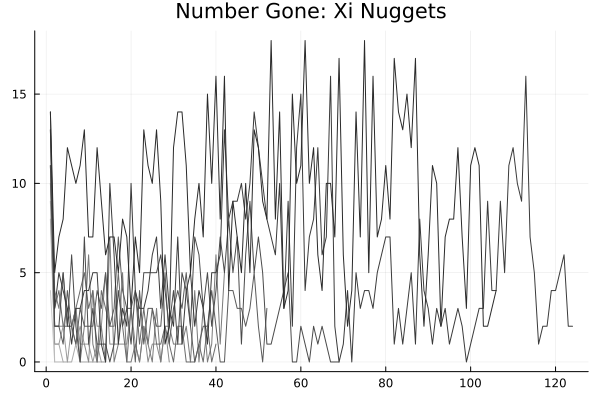

In [334]:
plot(title="Number Gone: Xi Nuggets")

for job in low:4:high
    color = h16(202-(job-low)*4)
    plot!([i for i in 1:length(num_gone[job-low+1])], num_gone[job-low+1], color=f"#{color}{color}{color}", linewidth=1)
end

display(plot!(legend=:none))

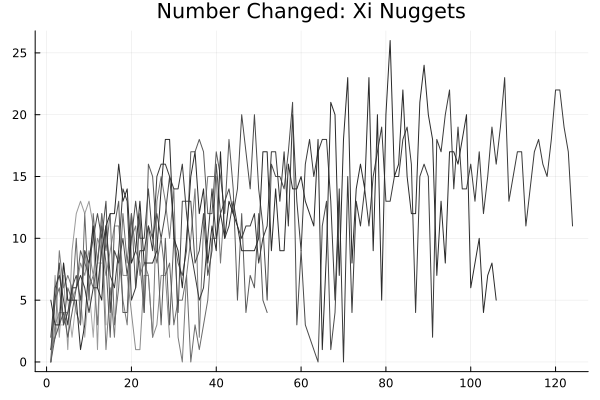

In [335]:
plot(title="Number Changed: Xi Nuggets")

for job in low:4:high
    color = h16(202-(job-low)*4)
    plot!([i for i in 1:length(num_changed[job-low+1])], num_changed[job-low+1], color=f"#{color}{color}{color}", linewidth=1)
end

display(plot!(legend=:none))

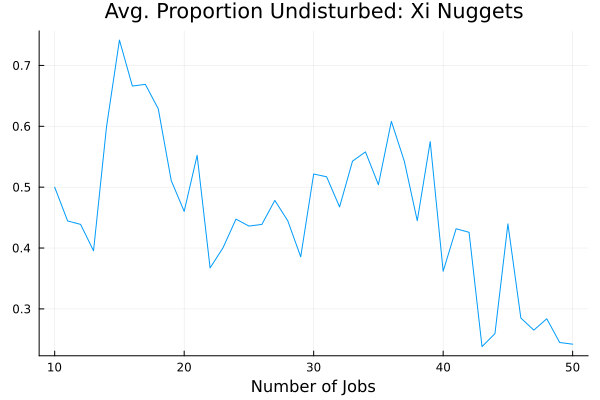

In [340]:
# get the average proportion undisturbed
avg_und = []
plot(title="Avg. Proportion Undisturbed: Xi Nuggets")
for job in low:high
    push!(avg_und, 1 - sum(prop_changed[job-low+1])/length(prop_changed[job-low+1]) - sum(prop_gone[job-low+1])/length(prop_gone[job-low+1]))
end

plot!([i for i in low:high], avg_und, legend=:none, xlabel="Number of Jobs")